In [1]:
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Optional Reddit dataset:

Load the Reddit emotion classifacation dataset. Only keep the samples that have the emotion 'anger', 'fear', 'joy', or 'sadness'. These 4 emotions are the emotions in the EEC dataset which will be used to measure gender bias. 

In [112]:
# # Dataset : https://www.kaggle.com/datasets/debarshichanda/goemotions
# df = pd.concat([
#     pd.read_csv('data/goemotions_1.csv'),
#     pd.read_csv('data/goemotions_2.csv'),
#     pd.read_csv('data/goemotions_3.csv')
# ])

# df['emotion'] = df.iloc[:, 9:].idxmax(1)
# df = df[df['emotion'].isin(['anger', 'fear', 'joy', 'sadness'])]
# df = df[['text', 'emotion']]

# print('Total number of samples: ', df.shape)
# df.sample(10)
# print('Number of samples in each emotion class: ')
# df['emotion'].value_counts()

Total number of samples:  (74751, 2)


,text,emotion
40949,Hey guys don't freak out but Widow has a POISO...,neutral
19284,My [NAME] He is a BEAST. Every possession he m...,fear
6242,A lack of the romantic partner is the stressfu...,sadness
30278,BY [NAME] THAT'S [NAME] MUSIC!,neutral
63400,"I read the books right after season one, and s...",neutral
10244,> since every character with a shield gets one...,neutral
54024,plz no foul trouble,fear
15316,But milk is beta food! Who wants that girly as...,anger
34402,"Don’t quote me on there being fish in there, i...",neutral
56168,"Don't be so damn lazy, just type NEW YEAR'S EV...",neutral


Number of samples in each emotion class: 


neutral    55298
anger       7956
joy         5120
sadness     3863
fear        2514
Name: emotion, dtype: int64

Load the SemEval 2018 - task E-c dataset which contains Tweets labels by the emotions 'anger', 'fear', 'joy', or 'sadness'. 

*Source: https://competitions.codalab.org/competitions/17751#learn_the_details-datasets

In [2]:
df = pd.concat([
    pd.read_csv('/Users/adammiyauchi/Downloads/2018-E-c-En-train.tsv', delimiter='\t', encoding='utf-8', na_values='NONE'),
    pd.read_csv('/Users/adammiyauchi/Downloads/2018-E-c-En-test.tsv', delimiter='\t', encoding='utf-8', na_values='NONE'),
    pd.read_csv('/Users/adammiyauchi/Downloads/2018-E-c-En-dev.tsv', delimiter='\t', encoding='utf-8', na_values='NONE'),
])
df = (df
    .drop('ID', axis=1)
    .rename(columns={'Tweet': 'text'})
)

df['emotion'] = df.iloc[:, 1:].idxmax(1)
df = df[df['emotion'].isin(['anger', 'fear', 'joy', 'sadness'])]
df = df[['text', 'emotion']]

print('Total number of samples: ', df.shape)
df.sample(10)
print('Number of samples in each emotion class: ')
df['emotion'].value_counts()


Total number of samples:  (5847, 2)


,text,emotion
2843,There goes the butterflies in my stomach. #an...,fear
4096,@TalkTalkCare how on earth can I send an emai...,anger
824,@Kailyew hahah tiff sent me that too😂,joy
6409,@CBSBigBrother she's pathetic!!! Hated Nicole ...,anger
1086,@CallofDuty how do u guys determine teams? Cau...,anger
1537,@SkyNews when the East wind blue in summer in ...,fear
4619,Check out @VovimPrgel - From Scotland #gamer #...,fear
43,Smile!!! #happy #smile,joy
4516,"@ycfcnick the city is famous for the shambles,...",sadness
2386,@Dubai92 try asking for a cheeseburger with on...,anger


Number of samples in each emotion class: 


anger      3077
joy        1938
fear        629
sadness     203
Name: emotion, dtype: int64

Clean text and map emotion classes to integers. 

In [3]:
import string
import nltk
from nltk.corpus import stopwords
import emoji
import re

def remove_punctuation(text):
    ans = ''
    for i in text:     
        if i not in string.punctuation:
            ans += i    
    return ans

def remove_stopwords(text):
    return ' '.join([word for word in text.split(" ") if word not in set(stopwords.words('english'))])

def remove_emoji(text):
    return emoji.demojize(text)

def remove_url(text):
    return re.sub(r"http:\S+",'', text)

def preprocess_text(text):
    return remove_punctuation(remove_stopwords(remove_emoji(remove_url(text))))

def emotion_to_int(emotion):
    if emotion == 'sadness': return 0
    elif emotion == 'anger': return 1
    elif emotion == 'joy': return 2
    elif emotion == 'fear': return 3
    # else: return 4  # neutral

def int_to_emotion(emotion_int):
    if emotion_int == 0: return 'sadness'
    elif emotion_int == 1: return 'anger'
    elif emotion_int == 2: return 'joy'
    elif emotion_int == 3: return 'fear'
    # else: return 'neutral'  # neutral



df['text'] = df['text'].apply(lambda x: preprocess_text(x))

labels = ['sadness', 'anger', 'joy', 'fear']
df['emotion'] = df['emotion'].apply(lambda x: emotion_to_int(x))

Split the data into training (2/3) & testing sets (1/3).

In [4]:
from sklearn.model_selection import train_test_split

X, y = df['text'], df['emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Baseline BERT model
Train a baseline BERT base uncased model with a single fully connected layer for classifacation. 
For ease, use the bert_sklearn repo (https://github.com/charles9n/bert-sklearn) to do this. 

In [5]:
from bert_sklearn import BertClassifier     
from bert_sklearn import load_model
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

baseline_BERT = BertClassifier()

baseline_BERT.num_mlp_layers = 1
baseline_BERT.epochs = 3    

baseline_BERT.fit(X_train, y_train)
baseline_BERT_df_pred = baseline_BERT.predict(X_test)

savefile='models/baselineBERT_SemEval2018TaskEC.bin'
baseline_BERT.save(savefile)
# baseline_BERT = load_model(savefile)


/Users/adammiyauchi/.pyenv/versions/3.10.3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Building sklearn text classifier...
Loading bert-base-uncased model...
Using mlp with D=768,H=500,K=4,n=1
Loading Pytorch checkpoint
train data size: 3526, validation data size: 391


Training  :   0%|          | 0/110 [00:00<?, ?it/s]/Users/adammiyauchi/.pyenv/versions/3.10.3/lib/python3.10/site-packages/bert_sklearn/model/pytorch_pretrained/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1174.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Validating: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]

Epoch 1, Train loss: 0.7901, Val loss: 0.5193, Val accy: 80.56%



Validating: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]

Epoch 2, Train loss: 0.3839, Val loss: 0.4878, Val accy: 82.61%



Validating: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]

Epoch 3, Train loss: 0.2108, Val loss: 0.5064, Val accy: 82.86%


BertClassifier(do_lower_case=True, label_list=array([0, 1, 2, 3]),
               num_mlp_layers=1)

Predicting: 100%|██████████| 242/242 [01:56<00:00,  2.09it/s]


In [6]:
from sklearn.metrics import classification_report

print(classification_report(y_test, baseline_BERT_df_pred, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.47      0.42      0.44        67
       anger       0.85      0.89      0.87      1009
         joy       0.85      0.83      0.84       635
        fear       0.74      0.67      0.70       219

    accuracy                           0.83      1930
   macro avg       0.73      0.70      0.72      1930
weighted avg       0.83      0.83      0.83      1930



Load the Equity Evaluation Corpus (EEC) which will be used to measure gender bias. 

In [7]:
eec = pd.read_csv('data/Equity-Evaluation-Corpus.csv')

eec = eec[~eec['Emotion'].isna()]
eec['Sentence'] = eec['Sentence'].apply(preprocess_text)
eec['Emotion'] = eec['Emotion'].apply(emotion_to_int)
eec['TemplateGender'] = eec['Template'] + eec['Gender']
eec.shape
eec.head()

# eec = eec[eec['Template'] == '<person subject> feels <emotion word>.'] # reduced data while developing

(8400, 9)

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word,TemplateGender
0,2018-En-mystery-05498,Alonzo feels angry,<person subject> feels <emotion word>.,Alonzo,male,African-American,1,angry,<person subject> feels <emotion word>.male
1,2018-En-mystery-11722,Alonzo feels furious,<person subject> feels <emotion word>.,Alonzo,male,African-American,1,furious,<person subject> feels <emotion word>.male
2,2018-En-mystery-11364,Alonzo feels irritated,<person subject> feels <emotion word>.,Alonzo,male,African-American,1,irritated,<person subject> feels <emotion word>.male
3,2018-En-mystery-14320,Alonzo feels enraged,<person subject> feels <emotion word>.,Alonzo,male,African-American,1,enraged,<person subject> feels <emotion word>.male
4,2018-En-mystery-14114,Alonzo feels annoyed,<person subject> feels <emotion word>.,Alonzo,male,African-American,1,annoyed,<person subject> feels <emotion word>.male


In [8]:
def evaluate_eec_gender_bias(model):
    eec['pred'] = model.predict(eec['Sentence'])
    eec['correct'] = eec['Emotion'] == eec['pred']

    bias = 0
    for template in list(eec['Template'].unique()):
        m_pred = eec[(eec['Template'] == template) & (eec['Gender'] == 'male')]['pred'].values
        f_pred = t_f = eec[(eec['Template'] == template) & (eec['Gender'] == 'female')]['pred'].values
        bias += np.sum(m_pred != f_pred)
    
    return bias / (eec.shape[0] / 2)


In [9]:
baseline_model_bias = evaluate_eec_gender_bias(baseline_BERT)
baseline_model_bias

Predicting: 100%|██████████| 1050/1050 [06:42<00:00,  2.61it/s]


0.03428571428571429

### Baseline BERT model performance and analysis:
- Accuracy: 0.83
- F1: 0.72
- Bias: 0.03428571428571429

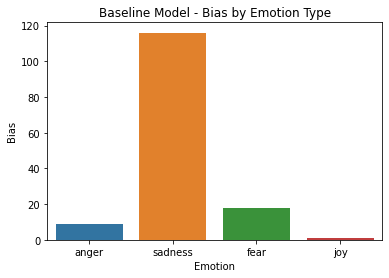

In [10]:
import seaborn as sns

# Bias by emotion type
emotions = list(eec['Emotion'].unique())
bias = []
for emotion in emotions:
    m_pred = eec[(eec['Emotion'] == emotion) & (eec['Gender'] == 'male')]['pred'].values
    f_pred = t_f = eec[(eec['Emotion'] == emotion) & (eec['Gender'] == 'female')]['pred'].values
    bias.append(np.sum(m_pred != f_pred))

emotion_bias = pd.DataFrame({'Emotion': emotions, 'Bias': bias})
emotion_bias['Emotion'] = emotion_bias['Emotion'].apply(int_to_emotion)
_ = sns.barplot(
    data=emotion_bias,
    x='Emotion', y='Bias'
).set(
    title='Baseline Model - Bias by Emotion Type'
)

[Text(0.5, 1.0, 'Baseline Model - Number of Correct EEC Prediction by Gender & Emotion')]

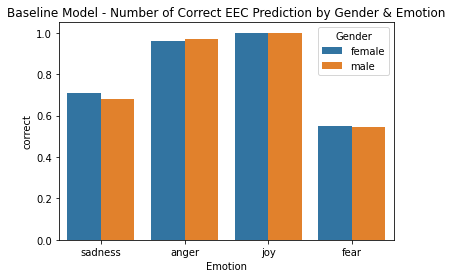

In [11]:
# Number of incorrect prediction by emotion type for M vs F
pred_by_emotion_gender = (eec.groupby(['Emotion', 'Gender'])['correct'].sum() / eec.groupby(['Emotion', 'Gender'])['correct'].count()).to_frame().reset_index()
pred_by_emotion_gender['Emotion'] = pred_by_emotion_gender['Emotion'].apply(int_to_emotion)
sns.barplot(
    data=pred_by_emotion_gender,
    x='Emotion', y='correct', hue='Gender'
).set(title='Baseline Model - Number of Correct EEC Prediction by Gender & Emotion')

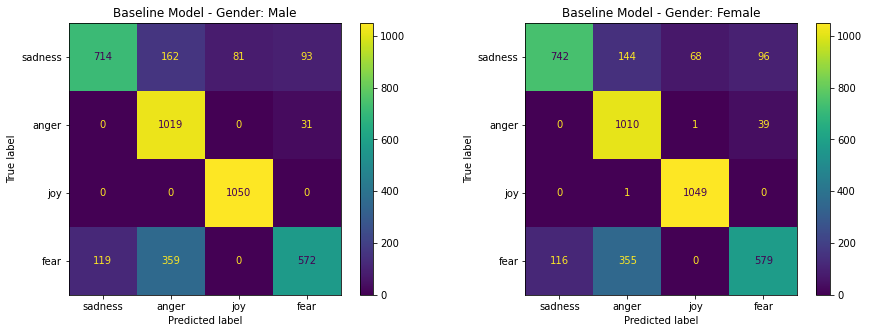

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

_ = ax[0].set_title('Baseline Model - Gender: Male')
ax[0] = ConfusionMatrixDisplay(
    confusion_matrix(eec[eec['Gender'] == 'male']['Emotion'], eec[eec['Gender'] == 'male']['pred']), 
    display_labels=labels,
).plot(ax=ax[0])

_ = ax[1].set_title('Baseline Model - Gender: Female')
ax[1] = ConfusionMatrixDisplay(
    confusion_matrix(eec[eec['Gender'] == 'female']['Emotion'], eec[eec['Gender'] == 'female']['pred']), 
    display_labels=labels,
).plot(ax=ax[1])


### Gender balanced dataset. 
The following methods will be performed to "gender balance" the dataset:

1. If a input contains any gendered word (him, she, mother, son, etc.) create a new input where the gendered terms are the gender counterparts. For example, the input 'He believed Ireland had a right to exist' contains the gendered term 'he'. A new input is created in which 'he' is replaced with 'she' - 'She believed Ireland had a right to exist.' A list of word pairs was optained from https://paperswithcode.com/paper/man-is-to-computer-programmer-as-woman-is-to. 
2. Mask all person name. Use a pretrained BERT-NER model to identify the names of people. Replace the name of people with the string 'NAME'. 

In [13]:
gender_word_pairs = [["woman", "man"], ["girl", "boy"], ["she", "he"], ["mother", "father"], ["daughter", "son"], ["gal", "guy"], ["female", "male"], ["her", "his"], ["herself", "himself"], ["Mary", "John"], ["monastery", "convent"], ["spokesman", "spokeswoman"], ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"], ["councilman", "councilwoman"], ["grandpa", "grandma"], ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"], ["testosterone", "estrogen"], ["uncle", "aunt"], ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"], ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], ["brothers", "sisters"], ["businessman", "businesswoman"], ["chairman", "chairwoman"], ["colt", "filly"], ["congressman", "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"], ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"], ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], ["gentlemen", "ladies"], ["grandfather", "grandmother"], ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], ["his", "her"], ["king", "queen"], ["kings", "queens"], ["male", "female"], ["males", "females"], ["man", "woman"], ["men", "women"], ["nephew", "niece"], ["prince", "princess"], ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]]

df_balanced = df.copy()
df_balanced.head(10)


,text,emotion
1,Whatever decide make sure makes happy,2
2,MaxKellerman also helps majority NFL coaching...,1
3,Accept challenges literally even feel exhilara...,2
4,My roommate okay cant spell autocorrect terrib...,1
5,No thats cute Atsu probably shy photos cherry ...,2
7,Rooneys fucking untouchable he Been fucking dr...,1
9,BossUpJaee pussy weak I heard stfu bitch You ...,1
11,And hard dance devil backnSo shake off,1
12,Tiller breezy collab album Rapping singing pro...,2
13,SO girl hit carnot get lucky w scratch also sp...,1


Balance gendered words

In [14]:
def swap_gender_word(text): 
    res = text
    for word in text.split(' '):
        for pair in gender_word_pairs:
            if word.lower() in pair:
                res = res.replace(word, pair[pair.index(word.lower())-1])
    return res

df_balanced_temp = df_balanced.copy()
df_balanced['text'] = df_balanced['text'].apply(lambda x: swap_gender_word(x))
df_balanced = pd.concat([df_balanced, df_balanced_temp]).drop_duplicates()

Mask names of people

In [15]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
Bert_NER = AutoModelForTokenClassification.from_pretrained('Jean-Baptiste/camembert-ner')
ner_pipeline = pipeline('ner', model=Bert_NER, tokenizer=tokenizer, aggregation_strategy='simple')

def mask_names(text):
    ents = ner_pipeline(text)
    res = text
    for ent in ents:
        if ent['entity_group'] == 'PER':
            res = res.replace(ent['word'], 'NAME')
    return res

df_balanced['text'] = df_balanced['text'].apply(mask_names)

Train a BERT model with a single FC classifacation layer using the debiased dataset

In [16]:
X, y = df_balanced['text'], df_balanced['emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

dataset_debias_BERT = BertClassifier()
dataset_debias_BERT.num_mlp_layers = 1
dataset_debias_BERT.epochs = 3    

dataset_debias_BERT.fit(X_train, y_train)
dataset_debias_BERT_df_pred = dataset_debias_BERT.predict(X_test)

savefile='models/dataset_debias_BERT_SemEval2018TaskEC.bin'
dataset_debias_BERT.save(savefile)
# dataset_debias_BERT = load_model(savefile)


Building sklearn text classifier...
Loading bert-base-uncased model...
Using mlp with D=768,H=500,K=4,n=1
Loading Pytorch checkpoint
train data size: 3820, validation data size: 424


Validating: 100%|██████████| 53/53 [00:45<00:00,  1.16it/s]

Epoch 1, Train loss: 0.7762, Val loss: 0.4983, Val accy: 83.49%



Validating: 100%|██████████| 53/53 [00:45<00:00,  1.17it/s]

Epoch 2, Train loss: 0.3637, Val loss: 0.4923, Val accy: 84.67%



Validating: 100%|██████████| 53/53 [00:45<00:00,  1.17it/s]

Epoch 3, Train loss: 0.1982, Val loss: 0.5009, Val accy: 83.73%


BertClassifier(do_lower_case=True, label_list=array([0, 1, 2, 3]),
               num_mlp_layers=1)

Predicting: 100%|██████████| 262/262 [02:02<00:00,  2.13it/s]


In [17]:
print(classification_report(y_test, dataset_debias_BERT_df_pred, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.36      0.41      0.38        78
       anger       0.87      0.84      0.85      1104
         joy       0.83      0.86      0.84       685
        fear       0.67      0.68      0.67       224

    accuracy                           0.81      2091
   macro avg       0.68      0.70      0.69      2091
weighted avg       0.81      0.81      0.81      2091



In [18]:
data_debias_model_bias = evaluate_eec_gender_bias(dataset_debias_BERT)


print('Baseline model bias: ', baseline_model_bias)
print('Dataset debias model bias: ', data_debias_model_bias)
print(f'Reduction: {baseline_model_bias - data_debias_model_bias} ({round((data_debias_model_bias - baseline_model_bias) / baseline_model_bias * 100, 2)}%)')

Predicting: 100%|██████████| 1050/1050 [06:18<00:00,  2.78it/s]

Baseline model bias:  0.03428571428571429
Dataset debias model bias:  0.023809523809523808
Reduction: 0.01047619047619048 (-30.56%)


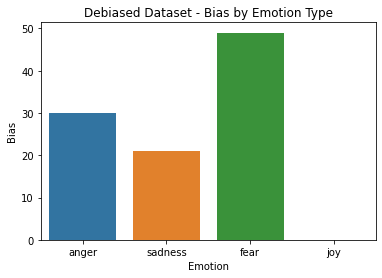

In [19]:
# Bias by emotion type
emotions = list(eec['Emotion'].unique())
bias = []
for emotion in emotions:
    m_pred = eec[(eec['Emotion'] == emotion) & (eec['Gender'] == 'male')]['pred'].values
    f_pred = t_f = eec[(eec['Emotion'] == emotion) & (eec['Gender'] == 'female')]['pred'].values
    bias.append(np.sum(m_pred != f_pred))

emotion_bias = pd.DataFrame({'Emotion': emotions, 'Bias': bias})
emotion_bias['Emotion'] = emotion_bias['Emotion'].apply(int_to_emotion)
_ = sns.barplot(
    data=emotion_bias,
    x='Emotion', y='Bias'
).set(
    title='Debiased Dataset - Bias by Emotion Type'
)

[Text(0.5, 1.0, 'Debiased Dataset - Numbeer of Correct EEC Predictions by Gender & Emotion')]

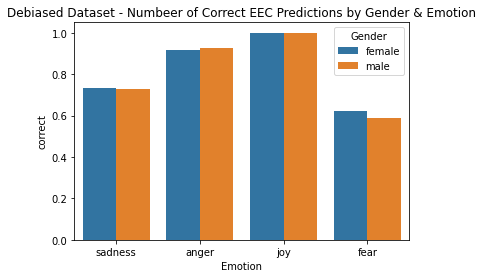

In [20]:
# Number of incorrect prediction by emotion type for M vs F
pred_by_emotion_gender = (eec.groupby(['Emotion', 'Gender'])['correct'].sum() / eec.groupby(['Emotion', 'Gender'])['correct'].count()).to_frame().reset_index()
pred_by_emotion_gender['Emotion'] = pred_by_emotion_gender['Emotion'].apply(int_to_emotion)
sns.barplot(
    data=pred_by_emotion_gender,
    x='Emotion', y='correct', hue='Gender'
).set(title='Debiased Dataset - Numbeer of Correct EEC Predictions by Gender & Emotion')

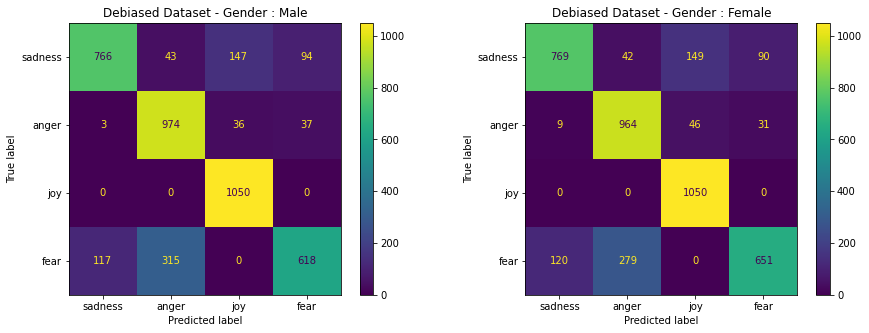

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

_ = ax[0].set_title('Debiased Dataset - Gender : Male')
ax[0] = ConfusionMatrixDisplay(
    confusion_matrix(eec[eec['Gender'] == 'male']['Emotion'], eec[eec['Gender'] == 'male']['pred']), 
    display_labels=labels,
).plot(ax=ax[0])

_ = ax[1].set_title('Debiased Dataset - Gender : Female')
ax[1] = ConfusionMatrixDisplay(
    confusion_matrix(eec[eec['Gender'] == 'female']['Emotion'], eec[eec['Gender'] == 'female']['pred']), 
    display_labels=labels,
).plot(ax=ax[1])
